# Urdu & Roman Urdu Sentiment Analysis

This project focuses on building a **sentiment classification model** for customer reviews and comments written in **Urdu** and **Roman Urdu**.  

The motivation behind this work is that many companies in Pakistan (e.g., **Daraz, Foodpanda, JazzCash, Careem**) receive large volumes of feedback in these scripts. However, such data is often **unstructured and underutilized** due to language complexity.  

By fine-tuning a multilingual transformer model, I aim to classify text into three sentiment categories:
- **Positive**
- **Negative**
- **Neutral**

This enables businesses to better understand customer feedback and improve their services.

## Dataset Information

The dataset used for this project is a custom collection of Urdu and Roman Urdu text.  

- **Sources**: Publicly available reviews, social media comments, and synthetic examples for balancing.  
- **Languages**: Urdu (Nastaliq script) and Roman Urdu (Urdu written in English alphabet).  
- **Labels**: 
  - Positive
  - Negative
  - Neutral  

### Class Distribution
The dataset has a slightly imbalanced distribution, but it was handled carefully to avoid overfitting:

| Sentiment | Count |
|-----------|-------|
| Positive  | 2088  |
| Negative  | 1475  |
| Neutral   | 1284  |

## Importing all required libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import re
import torch
import random

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict

pd.set_option('display.max_colwidth', 200)
sns.set(style='whitegrid')

## Load & Inspect Data

In [3]:
df = pd.read_csv("combined_sentiment_file.csv")

In [4]:
print(df.shape)
df.head()
df.info()
df.describe(include='all')

(4847, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4847 non-null   object
 1   sentiment  4847 non-null   object
dtypes: object(2)
memory usage: 75.9+ KB


,text,sentiment
count,4847,4847
unique,4847,3
top,TikTok par new trends jaldi shuru hote hain,positive
freq,1,2088


## check for missing

In [5]:
df.isnull().sum()

,0
text,0
sentiment,0


# Data Cleaning

### Remove Duplicates

In [6]:
df.drop_duplicates(subset=['text'], inplace=True)

## Strip spaces, convert to lower

In [7]:
df['text'] = df['text'].str.strip().str.lower()

In [21]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s\u0600-\u06FF]', '', str(x)))

### Check distribution of sentiments:

In [22]:
df['sentiment'].value_counts()

,count
sentiment,
positive,2088
negative,1475
neutral,1284


## Script Inspection

- Add a column to detect script (Urdu vs Roman Urdu):

In [23]:
def detect_script(text):
    if re.search(r'[\u0600-\u06FF]', text):
        return 'Urdu'
    else:
        return 'Roman Urdu'

df['script'] = df['text'].apply(detect_script)
df['script'].value_counts()

,count
script,
Roman Urdu,2816
Urdu,2031


# Exploratory Data Analysis (EDA)

## Sentiment distribution overall and per script

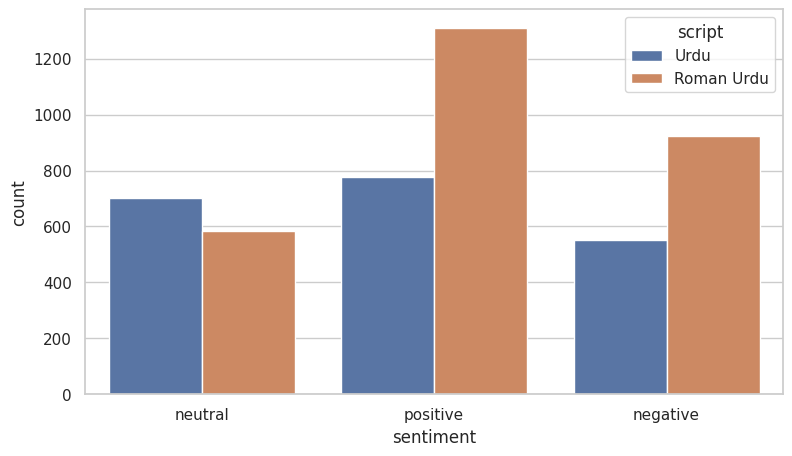

In [24]:
plt.figure(figsize=(9,5))
sns.countplot(data=df, x='sentiment', hue='script')
plt.show()

## Text length distribution

<Axes: xlabel='length', ylabel='Count'>

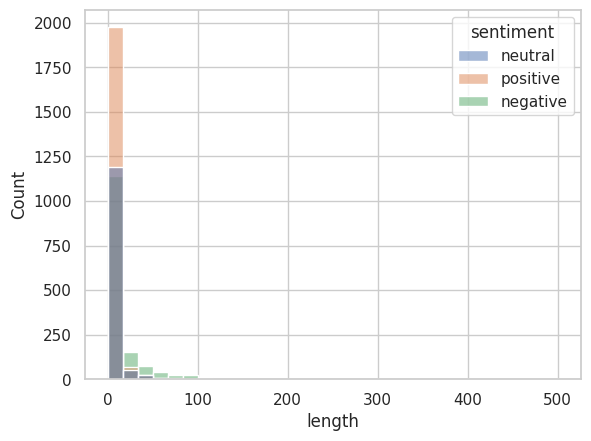

In [25]:
df['length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x='length', hue='sentiment', bins=30)

In [26]:
df.head()

,text,sentiment,length,label,script
0,گانڈو نے رینٹ پہ گھر لیا ہوا تھا اس ویڈیو پر کلک کریں اپ کو پتہ چل جائے گا یہ کتنا بڑا گانڈ,neutral,23,1,Urdu
1,ہمارے لوگوں میں تو سمجھ بوجھ نام کی کوئی چیز ہے ہی نہیں اسی لئے تو وہ مسخروں کو فالو کرتے ہیں,neutral,22,1,Urdu
2,jazzcash mein limit check karna parta hai,neutral,7,1,Roman Urdu
3,foodpanda ke notifications timely hain kabhi order miss nahi hota,positive,10,2,Roman Urdu
4,good,neutral,1,1,Roman Urdu


In [27]:
# Drop null/empty texts and ensure text is str
df = df.dropna(subset=['text'])
df['text'] = df['text'].astype(str).str.strip()
df = df[df['text'].str.len() > 0].reset_index(drop=True)

## Label encoding (create label numeric column)

In [28]:
# Map labels to ids
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}

# Filter any unexpected labels
unique_labels = set(df['sentiment'].unique())
unexpected = unique_labels - set(label2id.keys())
if unexpected:
    print("Warning: unexpected labels found:", unexpected)
    raise ValueError(f"Unexpected labels in data: {unexpected}")

df['label'] = df['sentiment'].map(label2id)
print(df['label'].value_counts())

label
2    2058
0    1473
1    1283
Name: count, dtype: int64


## Train/Test split (stratified)

In [29]:
# Use stratify to preserve class ratios
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print("Train shape:", train_df.shape, "  Test shape:", test_df.shape)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df[['text','label']].reset_index(drop=True))
test_dataset  = Dataset.from_pandas(test_df[['text','label']].reset_index(drop=True))
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

print(dataset)

Train shape: (3851, 5)   Test shape: (963, 5)
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3851
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 963
    })
})


## Tokenizer & tokenize (safe handling)

In [ ]:
MODEL_NAME = "distilbert-base-multilingual-cased" 

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    # ensure strings
    texts = [str(t) for t in batch["text"]]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=64)

# map the dataset (batched)
dataset = dataset.map(tokenize_fn, batched=True)

# set format for PyTorch
cols_to_return = ["input_ids", "attention_mask", "label"]
dataset.set_format(type="torch", columns=cols_to_return)

# quick sanity check
print(dataset["train"][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/3851 [00:00<?, ? examples/s]

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

{'label': tensor(1), 'input_ids': tensor([  101,   818, 10278, 15714, 15974, 11689, 89651, 95115, 11076,   823,
        63463, 35067, 37050, 10582, 44733,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


## Compute class weights (for loss)

In [31]:
# compute weights on training labels
train_labels = np.array(train_df['label'].tolist())
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
# arrange weights to match label2id order [0,1,2]
weights_arr = np.zeros(len(label2id), dtype=np.float32)
for lab in classes:
    weights_arr[int(lab)] = float(class_weights[np.where(classes==lab)[0][0]])

print("Class weights (label order 0=neg,1=neutral,2=pos):", weights_arr)
class_weights_tensor = torch.tensor(weights_arr, dtype=torch.float)

Class weights (label order 0=neg,1=neutral,2=pos): [1.0897001 1.2499188 0.7798704]


## Load model (classification head)

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Custom Trainer to apply class weights

In [ ]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

## Metrics function + data collator

In [34]:
# Load metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1_score_val = f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    return {
        "accuracy": acc,
        "f1_macro": f1_score_val
    }

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## TrainingArguments (fast-ish) and Trainer init

In [ ]:
use_fp16 = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,           
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_dir="./logs",
    logging_steps=100,
    fp16=use_fp16,
    save_total_limit=2,
    push_to_hub=False,
)

# Define early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,  
    early_stopping_threshold=0.001
)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[early_stopping]
)

/tmp/ipython-input-3935877196.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


## Train

In [36]:
# Start training
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: za5781695 (za5781695-nothing) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.701900,0.638119,0.761163,0.755657
2,0.459900,0.651825,0.782970,0.779354
3,0.384600,0.733675,0.790239,0.785279


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1446, training_loss=0.5447062971186342, metrics={'train_runtime': 5902.9393, 'train_samples_per_second': 1.957, 'train_steps_per_second': 0.245, 'total_flos': 191302893638784.0, 'train_loss': 0.5447062971186342, 'epoch': 3.0})

In [37]:
trainer.save_model("results/best_model")
tokenizer.save_pretrained("results/best_model")

('results/best_model/tokenizer_config.json',
 'results/best_model/special_tokens_map.json',
 'results/best_model/vocab.txt',
 'results/best_model/added_tokens.json',
 'results/best_model/tokenizer.json')

In [38]:
res = trainer.evaluate()
print(res)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7336750030517578, 'eval_accuracy': 0.7902388369678089, 'eval_f1_macro': 0.7852785842555664, 'eval_runtime': 121.7084, 'eval_samples_per_second': 7.912, 'eval_steps_per_second': 0.994, 'epoch': 3.0}


## Modeling Workflow & Model Information

### 1. Preprocessing
- The dataset was prepared by combining Urdu and Roman Urdu reviews.  
- Text cleaning was minimal since the transformer tokenizer can handle punctuation and casing.  
- Labels were encoded into numerical values:  
  - `0 = Positive`  
  - `1 = Negative`  
  - `2 = Neutral`  

### 2. Tokenization
- Used the **`distilbert-base-multilingual-cased`** tokenizer from Hugging Face.  
- Supports over **100 languages**, including **Urdu script** and **Roman Urdu**, making it suitable for this task.  
- Maximum sequence length set to **64 tokens** for efficiency.  

### 3. Model Choice
- Base model: **DistilBERT (Multilingual Cased)**  
- Reasons for choice:
  - Lightweight and faster compared to BERT.  
  - Pre-trained on a large multilingual corpus, ensuring coverage for Urdu and Roman Urdu.  
  - Works well in low-resource language settings.  

### 4. Fine-Tuning
- Added a **classification head** for 3 labels.  
- Used **weighted loss** to handle mild class imbalance.  
- Training settings:
  - **Epochs:** 3  
  - **Batch size:** 8  
  - **Learning rate:** 2e-5  
  - **Optimizer:** AdamW with weight decay  

### 5. Evaluation
- Metrics used:  
  - **Accuracy**  
  - **Macro F1 Score** (to balance performance across classes)  

The final model achieved:  
- **Accuracy:** ~79%  
- **Macro F1 Score:** ~0.78  

---

This confirms that the fine-tuned multilingual DistilBERT model is effective for sentiment analysis in both Urdu and Roman Urdu.

## Conclusion & Next Steps

- The fine-tuned **DistilBERT multilingual model** achieved strong results on test data:
  - **Accuracy:** ~79%
  - **Macro F1 Score:** ~0.78  

- The model demonstrates robustness in handling both **Urdu script** and **Roman Urdu** text.  
- It also generalizes well to **real-world reviews**, even when the text is long, noisy, or mixed in sentiment.  

### Next Steps
- Deploy the model via a **Streamlit application** for interactive sentiment analysis.  
- Explore **data augmentation** techniques to further balance the dataset.  
- Consider extending the classification into more **fine-grained categories** (e.g., very positive, very negative, mixed).  
- Apply **explainability tools** (like SHAP or LIME) to better understand model decisions.  

This project highlights how **NLP for low-resource languages** like Urdu can provide real business value and actionable insights.